<a href="https://www.kaggle.com/code/asadalikhan92/notebooksubgit?scriptVersionId=255848033" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


0:	test: 0.9498535	best: 0.9498535 (0)	total: 1.93s	remaining: 32m 6s
200:	test: 0.9668984	best: 0.9668984 (200)	total: 6m 29s	remaining: 25m 49s
400:	test: 0.9691353	best: 0.9691353 (400)	total: 13m 33s	remaining: 20m 14s
600:	test: 0.9703269	best: 0.9703269 (600)	total: 21m 11s	remaining: 14m 3s
800:	test: 0.9709678	best: 0.9709678 (800)	total: 28m 47s	remaining: 7m 9s
999:	test: 0.9713746	best: 0.9713746 (999)	total: 36m 1s	remaining: 0us

bestTest = 0.9713745821
bestIteration = 999

Validation ROC AUC: 0.9713745820848023


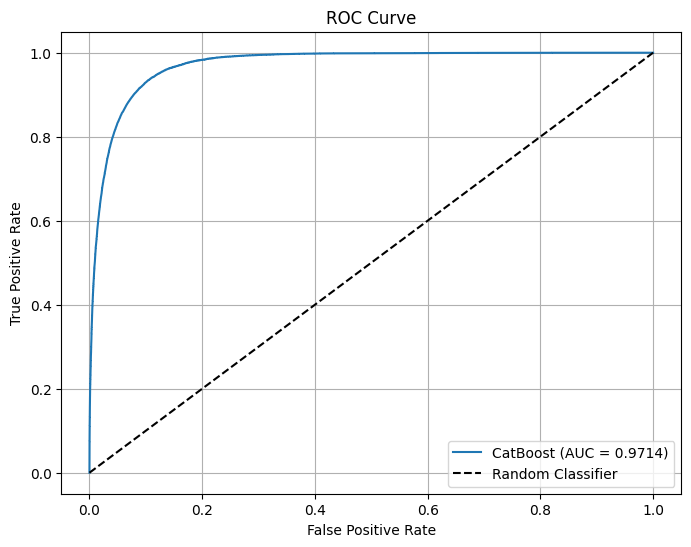

Submission file has been saved!


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from catboost import CatBoostClassifier, Pool  # Import Pool from catboost

# Step 1: Load and Preprocess Data
train_data = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')

# Convert all int64 columns to object in train_data
int_cols_train = train_data.select_dtypes(include=['int64']).columns
train_data[int_cols_train] = train_data[int_cols_train].astype('object')

# Convert all int64 columns to object in test_data
int_cols_test = test_data.select_dtypes(include=['int64']).columns
test_data[int_cols_test] = test_data[int_cols_test].astype('object')

# Convert y to integer type (binary classification)
y = train_data['y'].astype(int)  # Make sure y is integer

# Step 2: Feature Engineering - Combine categorical features
def create_combined_features(df):
    # Combine similar features to reduce dimensionality or capture interactions
    df['job_education'] = df['job'] + "_" + df['education']  # Interaction between job and education
    df['loan_default'] = df['loan'] + "_" + df['default']  # Interaction between loan and default status
    df['housing_balance'] = df['housing'] + "_" + df['balance'].apply(lambda x: 'high' if float(x) > 1000 else 'low')  # Combine housing and balance
    df['financial_status'] = df['loan'] + "_" + df['housing'] + "_" + df['default']  # Financial status based on loan, housing, and default
    df['month_day'] = df['month'] + "_" + df['day'].astype(str)  # Combine month and day for seasonal patterns
    df['duration_campaign'] = df['duration'].apply(lambda x: 'long' if x > 1000 else 'short') + "_" + df['campaign'].apply(lambda x: 'high' if x > 2 else 'low')
    df['previous_pdays'] = df['previous'].astype(str) + "_" + df['pdays'].astype(str)  # Interaction between previous and pdays
    
    # Grouping month into seasons (optional)
    seasons = {'jan': 'winter', 'feb': 'winter', 'mar': 'spring', 'apr': 'spring', 'may': 'spring',
               'jun': 'summer', 'jul': 'summer', 'aug': 'summer', 'sep': 'fall', 'oct': 'fall', 'nov': 'fall', 'dec': 'winter'}
    df['season'] = df['month'].map(seasons)
    
    return df

# Apply feature engineering
train_data = create_combined_features(train_data)
test_data = create_combined_features(test_data)

# Define the new combined categorical columns
categorical_cols = [
    'age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 
    'loan', 'contact', 'day', 'month', 'duration', 'campaign', 
    'pdays', 'previous', 'poutcome', 'job_education', 'loan_default', 'housing_balance', 'financial_status', 'month_day', 
                    'duration_campaign', 'previous_pdays', 'season'
]

# Label encode categorical columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    # Fit on the training data
    label_encoder.fit(train_data[col])

    # Transform the training data
    train_data[col] = label_encoder.transform(train_data[col])

    # Handle unseen labels in the test data
    test_data[col] = test_data[col].apply(lambda x: x if x in label_encoder.classes_ else 'unknown')

    # Add 'unknown' as a valid class and transform the test data
    label_encoder.classes_ = np.append(label_encoder.classes_, 'unknown')  # Add 'unknown' to classes
    test_data[col] = label_encoder.transform(test_data[col])

# Split out the features and labels for training
X = train_data.drop(columns=['id', 'y'])

# Step 2: Feature Scaling (only numerical features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=['int64', 'float64']))

# Step 3: Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: CatBoost Model
model = CatBoostClassifier(
    iterations=1000,             # Number of boosting iterations
    learning_rate=0.01,          # Lower learning rate for finer optimization
    depth=8,                     # Tree depth
    l2_leaf_reg=10,              # L2 regularization to prevent overfitting
    subsample=0.8,               # Fraction of samples for training each tree
    colsample_bylevel=0.8,       # Fraction of features for training each tree
    eval_metric='AUC',           # Optimize for AUC
    verbose=200                  # Print progress every 200 iterations
)

# Step 5: Train the model using Pool
from catboost import Pool

# Ensure categorical columns are of type 'object'
for col in categorical_cols:
    train_data[col] = train_data[col].astype('object')
    test_data[col] = test_data[col].astype('object')

# Create Pools using DataFrames (not NumPy arrays)
# Ensure categorical columns are set as category dtype
X_train, X_val, y_train, y_val = train_test_split(
    train_data.drop(columns=['id', 'y']), y, test_size=0.2, random_state=42
)

# Ensure categorical dtype
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

# Create Pools
train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
val_pool = Pool(X_val, y_val, cat_features=categorical_cols)

# Fit the model
model.fit(train_pool, eval_set=val_pool)

# Step 6: Evaluate on validation split
y_pred_proba = model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred_proba)
print("Validation ROC AUC:", val_auc)

# Step 7: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {val_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Label encode categorical columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    # Fit on the training data
    label_encoder.fit(test_data[col])

    # Transform the training data
    test_data[col] = label_encoder.transform(test_data[col])

    # Handle unseen labels in the test data by setting them to 'unknown'
    test_data[col] = test_data[col].apply(lambda x: x if x in label_encoder.classes_ else 'unknown')

    # Add 'unknown' as a valid class and transform the test data
    label_encoder.classes_ = np.append(label_encoder.classes_, 'unknown')  # Add 'unknown' to classes
    test_data[col] = label_encoder.transform(test_data[col])

# Split out the features and labels for training
X_test = test_data.drop(columns=['id'])


# Step 8: Test Data Prediction and Submission


test_pred_prob = model.predict_proba(X_test)[:, 1]

# Prepare the submission
submission = pd.DataFrame({
    'id': test_data['id'],
    'y': test_pred_prob
})

submission.to_csv('submission.csv', index=False)
print("Submission file has been saved!")